In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt

In [64]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep=r"\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

X = pd.DataFrame(data, columns=feature_names)
y = target

CRIM - уровень преступности на душу населения

ZN - доля земель под жилую застройку, зонированных под участки площадью более 25 000 кв. футов

INDUS - доля акров, не связанных с розничной торговлей, на город

CHAS - фиктивная переменная реки Чарльз (= 1, если участок ограничивает реку; 0 в противном случае)

NOX - уровень закиси азота (частей на 10 миллионов)

RM - среднее количество комнат в доме.

AGE - доля частных домов, построенных до 1940 года.

DIS - взвешенные расстояния до пяти бостонских центров занятости

RAD - индекс доступности радиальных автомагистралей.

TAX - ставка налога на недвижимость 

PTRATIO - соотношение числа учащихся и преподавателей в районе 

B - 1000 (Bk - 0,63)², где Bk - доля лиц афроамериканского происхождения по городам.

LSTAT - процент населения с более низким статусом

Целевая переменная - средняя стоимость домов в тысячах долларов

Посмотрим, как коррелируют признаки друг с другом и с целевой переменной. Видим, что есть нелинейные зависимости.

In [65]:
X2 = X.copy() #Делаем DataFrame X2, чтобы добавить в него целевую переменную и выводить корреляции вместе с ней
X2['y'] = y

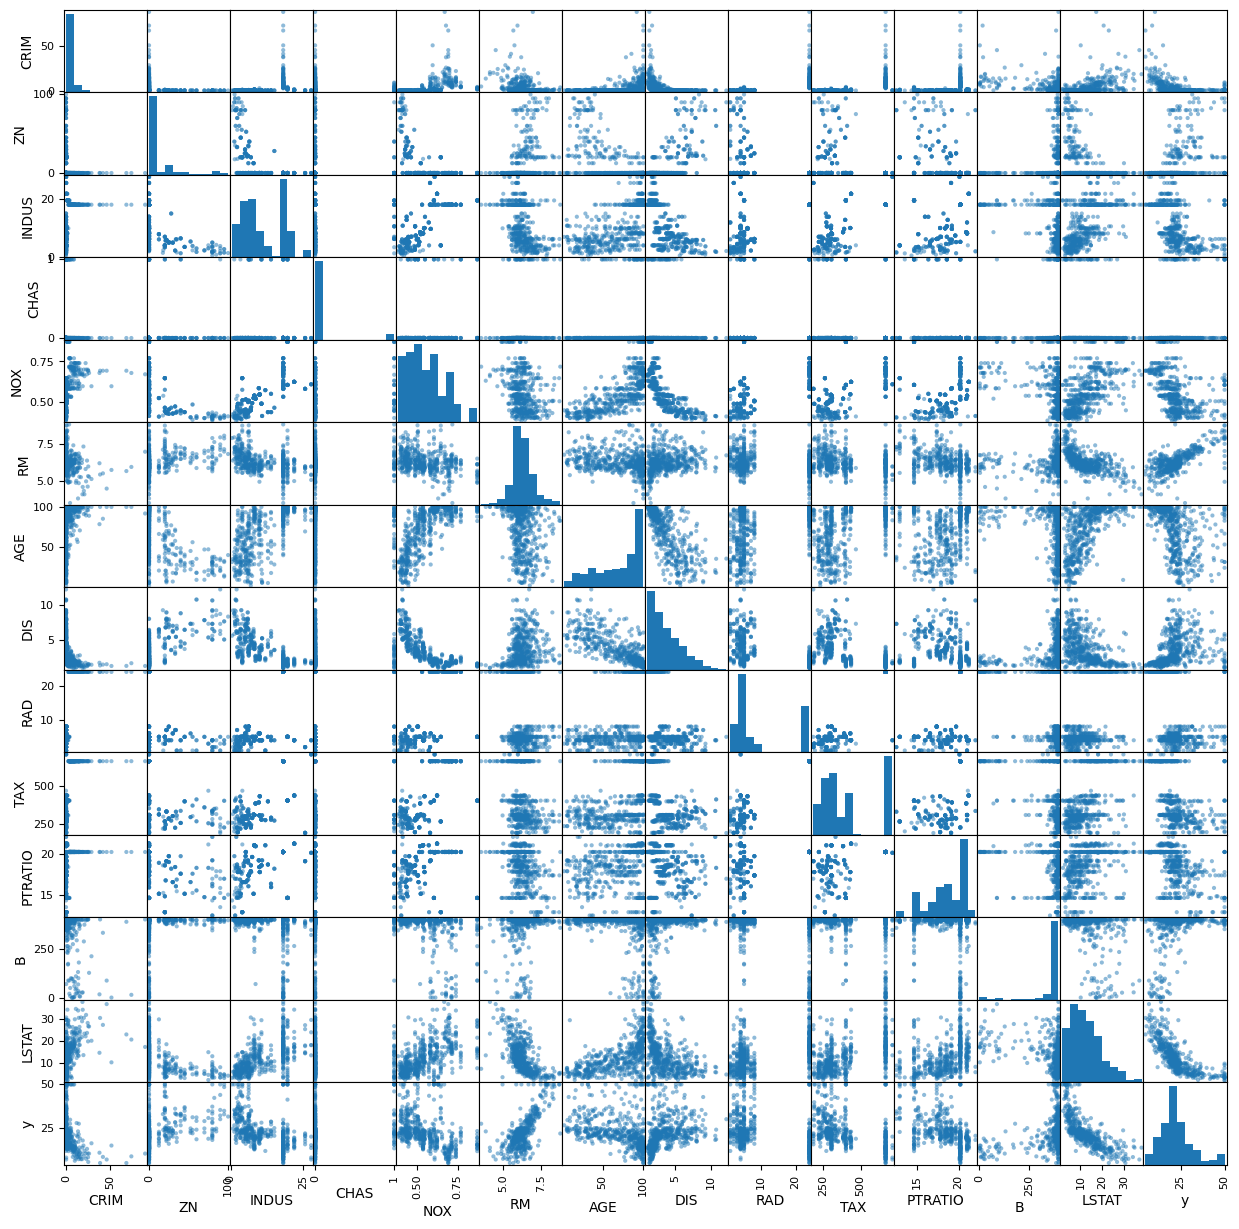

In [66]:
scatter = pd.plotting.scatter_matrix(X2, alpha=0.5, figsize = (15,15))

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=7)

<Axes: >

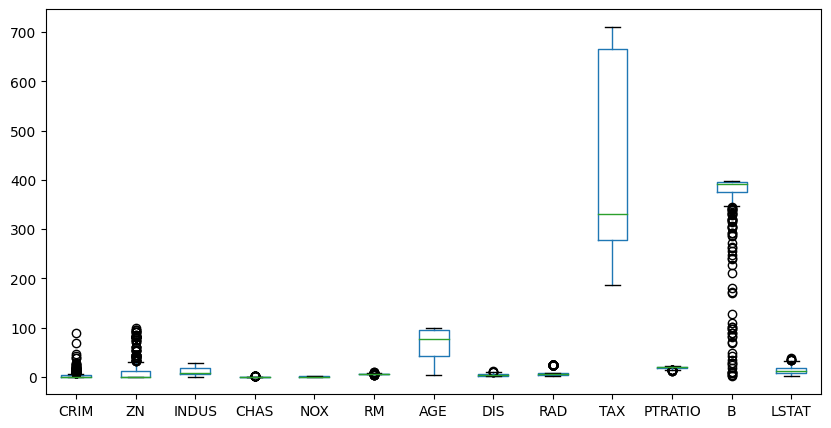

In [68]:
X_train.boxplot(grid=False, figsize=(10,5))

Замена экстремальных выбросов более 15IQR на значение границы 15IQR может немного улучшить результат модели (дополнительное задание для желающих)

In [69]:
"""
def replace_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR  # Граница 1.5 IQR
    upper_bound = Q3 + 1.5 * IQR  # Граница 1.5 IQR

    # Замена выбросов
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

for column in X_train.columns:
    replace_outliers(X_train, column)

X_train.boxplot(grid=False, figsize=(10, 5)) 
"""

'\ndef replace_outliers(df, column):\n    Q1 = df[column].quantile(0.25)\n    Q3 = df[column].quantile(0.75)\n    IQR = Q3 - Q1\n    lower_bound = Q1 - 1.5 * IQR  # Граница 1.5 IQR\n    upper_bound = Q3 + 1.5 * IQR  # Граница 1.5 IQR\n\n    # Замена выбросов\n    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])\n    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])\n\nfor column in X_train.columns:\n    replace_outliers(X_train, column)\n\nX_train.boxplot(grid=False, figsize=(10, 5)) \n'

Вся тренировка, настройка, оценка будет проходить на X_train, y_train. X_test, y_test - для финальной оценки

Дополнительно к имеющимся признакам сгенерируем полиномиальные признаки. В качестве модели возьмем линейную модель с L1 регуляризацией. В оценщике необходимо задать параметр max_iter = 50000, tol=0.01 - увеличить количество эпох, чтобы подойти ближе к точки минимума.

Используем конвейер, не забываем про масштабирование. Для масштабирования лучше использовать вариант не снижающий значимость выбросов.

Подобрать параметры - степень полинома 1-2, коэффициент регуляризации модели - степени 10 от -3 до 3.
Кросс-валидация на 5ти блоках, scoring = 'r2'

In [70]:
#c = np.logspace(-3,3,7)

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  
    ('poly', PolynomialFeatures()), 
    ('lasso', Lasso(max_iter=50000, tol=0.01))  
])

param_grid = {
    'poly__degree': [1, 2], # 'poly__degree': [1, 2]
    'lasso__alpha': np.logspace(-2, 5, 8) # Коэффициенты регуляризации (10^-3 до 10^3)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, scoring='r2', cv=kf, n_jobs=-1, verbose=1) # verbose для логирования
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('poly', PolynomialFeatures()),
                                       ('lasso',
                                        Lasso(max_iter=50000, tol=0.01))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]),
                         'poly__degree': [1, 2]},
             scoring='r2', verbose=1)

Какие параметры оказались лучшими?
В качестве оценщика можно использовать grid_search.best_estimator_ 
Сколько получилось признаков после применения полиномизации? (у объекта PolynomialFeatures свойство .n_output_features_)
После регуляризации L1 сколько признаков значимо (имеют абсолютное значение больше единицы) Hint. sum([True,False,False]) = 1

In [71]:
print("Best parameters:", grid_search.best_params_)
print("Best R^2 score:", grid_search.best_score_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

best_poly = grid_search.best_estimator_.named_steps['poly']
n_output_features = best_poly.n_output_features_
print("Признаков после полиномизации:", n_output_features)

best_lasso = grid_search.best_estimator_.named_steps['lasso']  # Извлекаем Lasso из лучшей модели
lasso_coef = best_lasso.coef_
significant_features_count = np.sum(np.abs(lasso_coef) > 1)  # Считаем кол-во признаков, где abs(coef) > 1
print("Значимость признаков после L1 регуляризации:", significant_features_count)

Best parameters: {'lasso__alpha': 0.01, 'poly__degree': 2}
Best R^2 score: 0.8475918689834103
Признаков после полиномизации: 105
Значимость признаков после L1 регуляризации: 25


Оценить качество на отложенной выборке. В качестве оценщика можно взять grid_search.best_estimator_.
Вывести RMSE, r2. R2 должно получиться 0.8 и больше

In [72]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("RMSE на тестовой выборке:", rmse)
print("R^2 на тестовой выборке:", r2)

RMSE на тестовой выборке: 4.558717408224475
R^2 на тестовой выборке: 0.6634070296976502


Проверить остатки на гомоскедастичность и нормальное распределение

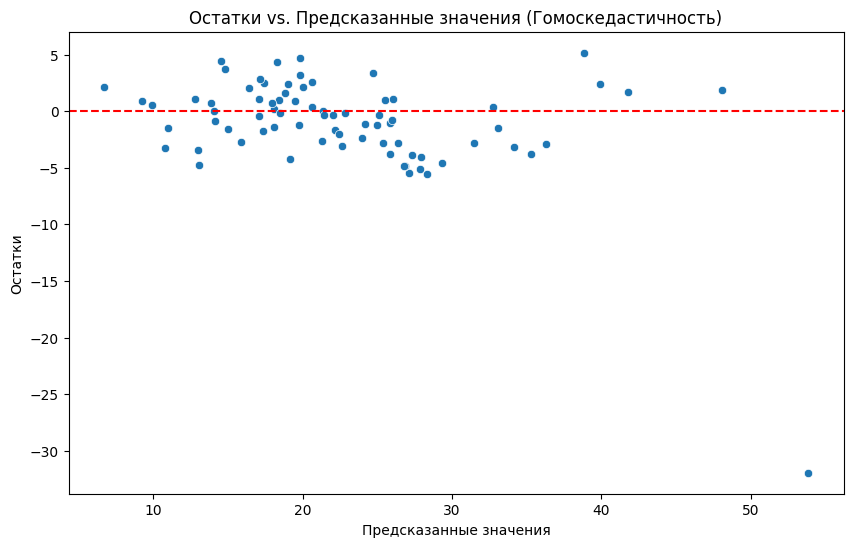

In [73]:
#остатки
residuals = y_test - y_pred

# График остатков vs. предсказанных значений
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.title('Остатки vs. Предсказанные значения (Гомоскедастичность)')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()



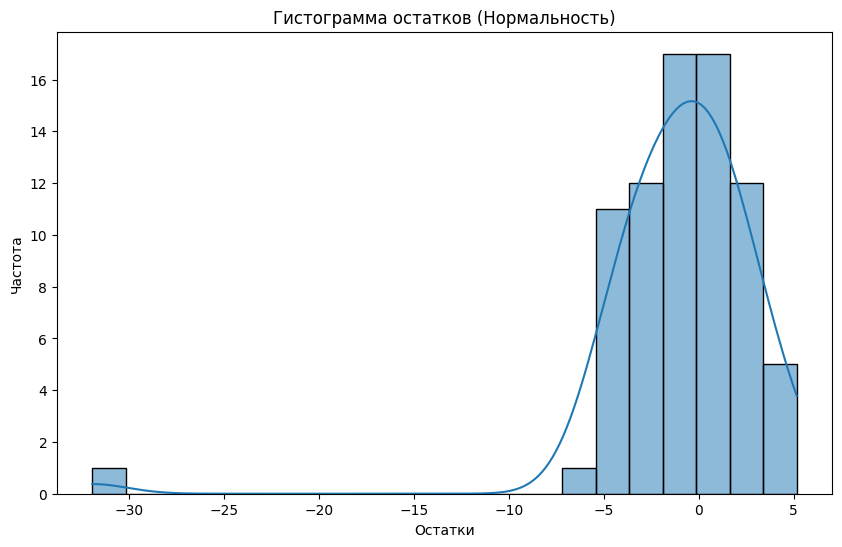

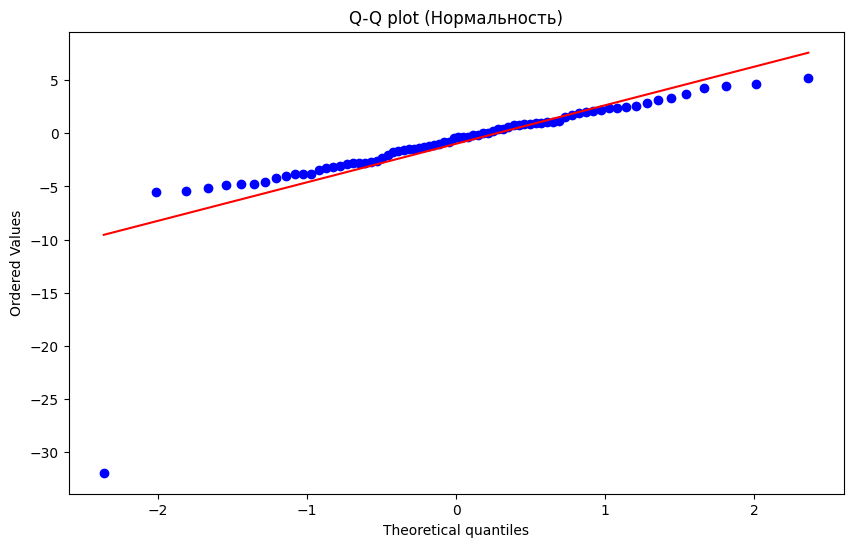

In [74]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Гистограмма остатков (Нормальность)')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

import scipy.stats as stats
# Q-Q plot (квантиль-квантиль)
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q plot (Нормальность)')
plt.show()

Увеличится ли качество на отложенной выборке, если для обучения взять больше образцов? (test_size 10% вместо 15% и модель из новых 5% )

In [75]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures()),
    ('lasso', Lasso(max_iter=50000, tol=0.01))
])

# 3. Определение сетки параметров для GridSearchCV
param_grid = {
    'poly__degree': [1, 2],
    'lasso__alpha': np.logspace(-3, 3, 7)
}

def train_and_evaluate(X, y, test_size, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    grid_search = GridSearchCV(pipeline, param_grid, scoring='r2', cv=kf, n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

#Обучение и оценка с test_size=0.15
rmse_15, r2_15 = train_and_evaluate(X, y, test_size=0.15, random_state=42)
print("Результаты с test_size=0.15:")
print("  RMSE:", rmse_15)
print("  R^2:", r2_15)

#Обучение и оценка с test_size=0.10
rmse_10, r2_10 = train_and_evaluate(X, y, test_size=0.10, random_state=42)
print("\nРезультаты с test_size=0.10:")
print("  RMSE:", rmse_10)
print("  R^2:", r2_10)


Результаты с test_size=0.15:
  RMSE: 2.501112827335637
  R^2: 0.9042082616028558

Результаты с test_size=0.10:
  RMSE: 2.4988543184412135
  R^2: 0.8999863673484878
